# Probability Calibration in Python

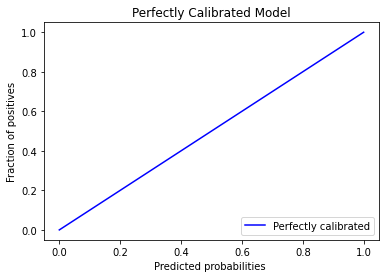

In [1]:
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot()

ax.plot([0, 1], [0, 1], "b-", label="Perfectly calibrated")
ax.set_ylabel("Fraction of positives")
ax.set_xlabel("Predicted probabilities ")
ax.set_title('Perfectly Calibrated Model')
ax.legend(loc="lower right")
plt.show()
fig.savefig('01_perfectly_calibration.png', tight=True, quality=100)

In [2]:
# Create dataset of classification task with many redundant and few
# informative features

import numpy as np
from sklearn import datasets
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import brier_score_loss, precision_score, recall_score, f1_score
np.random.seed(0)

X, y = datasets.make_classification(n_samples=100000, n_features=20, n_informative=2, n_redundant=2)

train_samples = 100
X_train = X[:train_samples]
X_test = X[train_samples:]
y_train = y[:train_samples]
y_test = y[train_samples:]

model_rfc = RandomForestClassifier()
model_rfc.fit(X_train, y_train)
y_pred_rfc = model_rfc.predict(X_test)

print("Precision: %0.2f" % precision_score(y_test, y_pred_rfc))
print("Recall: %0.2f" % recall_score(y_test, y_pred_rfc))
print("F1: %0.2f\n" % f1_score(y_test, y_pred_rfc))

model_lr = LogisticRegression()
model_lr.fit(X_train, y_train)
y_pred_lr = model_lr.predict(X_test)

print("Precision: %0.2f" % precision_score(y_test, y_pred_lr))
print("Recall: %0.2f" % recall_score(y_test, y_pred_lr))
print("F1: %0.2f" % f1_score(y_test, y_pred_lr))

Precision: 0.85
Recall: 0.92
F1: 0.89

Precision: 0.84
Recall: 0.86
F1: 0.85


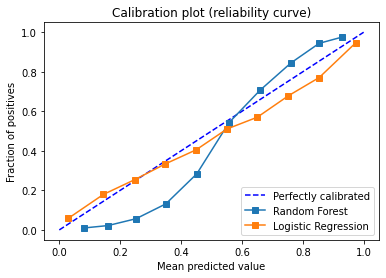

In [3]:
import matplotlib.pyplot as plt
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

fig = plt.figure()
ax = fig.add_subplot()
ax.plot([0, 1], [0, 1], "b--", label="Perfectly calibrated")
ax.set_ylabel("Fraction of positives")
ax.set_xlabel("Mean predicted value")
ax.set_title('Calibration plot (reliability curve)')

prob_pos_rfc = model_rfc.predict_proba(X_test)[:, 1]
fraction_of_positives_rfc, mean_predicted_value_rfc = calibration_curve(y_test, prob_pos_rfc, n_bins=10)
ax.plot(mean_predicted_value_rfc, fraction_of_positives_rfc, "s-", label="%s" % ('Random Forest'))

prob_pos_lr = model_lr.predict_proba(X_test)[:, 1]
fraction_of_positives_lr, mean_predicted_value_lr = calibration_curve(y_test, prob_pos_lr, n_bins=10)
ax.plot(mean_predicted_value_lr, fraction_of_positives_lr, "s-", label="%s" % ('Logistic Regression'))

ax.legend(loc="lower right")
plt.show()
fig.savefig('02_rf_lr.png', tight=True, quality=100)

# Brier Score

Brier score RFC: 0.12
Brier score LR: 0.16


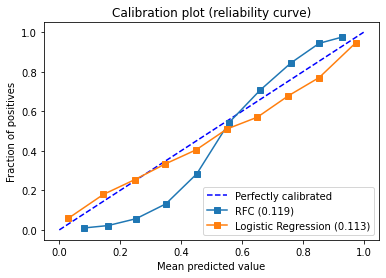

In [4]:
fig = plt.figure()
ax = fig.add_subplot()
ax.plot([0, 1], [0, 1], "b--", label="Perfectly calibrated")
ax.set_ylabel("Fraction of positives")
ax.set_xlabel("Mean predicted value")
ax.set_title('Calibration plot (reliability curve)')

model_rfc_score = brier_score_loss(y_test, y_pred_rfc, pos_label=y.max())
fraction_of_positives, mean_predicted_value = calibration_curve(y_test, prob_pos_rfc, n_bins=10)

ax.plot(mean_predicted_value, fraction_of_positives, "s-", label="%s (%0.3f)" % ('RFC', model_rfc_score))
print("Brier score RFC: %0.2f" % brier_score_loss(y_test, y_pred_rfc))


model_lr_score = brier_score_loss(y_test, prob_pos_lr, pos_label=y.max())
fraction_of_positives, mean_predicted_value = calibration_curve(y_test, prob_pos_lr, n_bins=10)

ax.plot(mean_predicted_value, fraction_of_positives, "s-", label="%s (%0.3f)" % ('Logistic Regression', model_lr_score))
print("Brier score LR: %0.2f" % brier_score_loss(y_test, y_pred_lr))

ax.legend(loc="lower right")
plt.show()
fig.savefig('03_rf_lr.png', tight=True, quality=100)

# Before: Cross validation

F1: 0.89
F1: 0.88
F1: 0.88


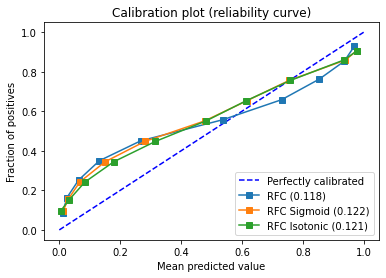

In [5]:
def get_calibration_curve_values(model, X_train, y_train, X_test, y_test): 
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    prob_pos = model.predict_proba(X_test)[:, 1]
    model_score = brier_score_loss(y_test, y_pred, pos_label=y.max())
    
    print("F1: %0.2f" % f1_score(y_test, y_pred))
    fraction_of_positives, mean_predicted_value = calibration_curve(y_test, prob_pos, n_bins=10)
    
    return(fraction_of_positives, mean_predicted_value, model_score)

fig = plt.figure()
ax = fig.add_subplot()
ax.plot([0, 1], [0, 1], "b--", label="Perfectly calibrated")
ax.set_ylabel("Fraction of positives")
ax.set_xlabel("Mean predicted value")
ax.set_title('Calibration plot (reliability curve)')

model_rfc = RandomForestClassifier()
mpv, fp, score = get_calibration_curve_values(model_rfc, X_train, y_train, X_test, y_test)
ax.plot(mpv, fp, "s-", label="%s (%1.3f)" % ('RFC', score))

calibrator_sigmoid = CalibratedClassifierCV(RandomForestClassifier(), cv=5, method='sigmoid')
mpv, fp, score = get_calibration_curve_values(calibrator_sigmoid, X_train, y_train, X_test, y_test)
ax.plot(mpv, fp, "s-", label="%s (%1.3f)" % ('RFC Sigmoid', score))

calibrator_isotonic = CalibratedClassifierCV(RandomForestClassifier(), cv=5, method='isotonic')
mpv, fp, score = get_calibration_curve_values(calibrator_sigmoid, X_train, y_train, X_test, y_test)
ax.plot(mpv, fp, "s-", label="%s (%1.3f)" % ('RFC Isotonic', score))

ax.legend(loc="lower right")
plt.show()
fig.savefig('04_before.png', tight=True, quality=100)

# Prefit

F1: 0.89
F1: 0.89
F1: 0.89


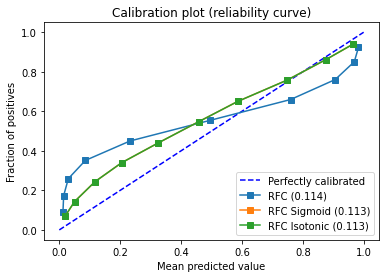

In [6]:
from sklearn.model_selection import train_test_split

fig = plt.figure()
ax = fig.add_subplot()
ax.plot([0, 1], [0, 1], "b--", label="Perfectly calibrated")
ax.set_ylabel("Fraction of positives")
ax.set_xlabel("Mean predicted value")
ax.set_title('Calibration plot (reliability curve)')

X_train, X_train2, y_train, y_train2 = train_test_split(X_train, y_train, test_size=0.5)

model_rfc = RandomForestClassifier()
mpv, fp, score = get_calibration_curve_values(model_rfc, X_train, y_train, X_test, y_test)
ax.plot(mpv, fp, "s-", label="%s (%1.3f)" % ('RFC', score))

calibrator_sigmoid = CalibratedClassifierCV(model_rfc, cv='prefit', method='sigmoid')
mpv, fp, score = get_calibration_curve_values(calibrator_sigmoid, X_train2, y_train2, X_test, y_test)
ax.plot(mpv, fp, "s-", label="%s (%1.3f)" % ('RFC Sigmoid', score))

calibrator_isotonic = CalibratedClassifierCV(model_rfc, cv='prefit', method='isotonic')
mpv, fp, score = get_calibration_curve_values(calibrator_sigmoid, X_train2, y_train2, X_test, y_test)
ax.plot(mpv, fp, "s-", label="%s (%1.3f)" % ('RFC Isotonic', score))

ax.legend(loc="lower right")
plt.show()
fig.savefig('05_after.png', tight=True, quality=100)